In [5]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import pandas as pd
from collections import Counter

# Get ROC from train set

In [2]:
cv_results = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\uncertainty\get_size_thresh.xlsx', sheet_name='Best train results (k=3)')
raw_train_results = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\uncertainty\get_size_thresh.xlsx', sheet_name='Raw train')

In [3]:
def get_roc(region: str, iters: int, steps: int) -> Tuple[dict, dict]:
    """Get the ROC curve for lipid and calcium and different thresholds for size

    Args:
        region (str): either lipid or calcium
        iters (int): number of iterations you want to check for the ROC
        steps (int): stepsize for the iters
    Returns:
        dict: dict with TPR {thresh size: tpr} and FPR {thresh size: FPR}
    """    

    tpr = {}
    fpr = {}

    for thresh in range(0, iters, steps):

        list_cm = []
        
        for i in range(len(cv_results)):
            
            #For FN and TN, no need to do anything
            if cv_results[region][i] == 0 and raw_train_results[region][i] == 1:
                list_cm.append('FN')

            elif cv_results[region][i] == 0 and raw_train_results[region][i] == 0:
                list_cm.append('TN')

            else:

                #For TP, cosnider it FN if the region is smaller than the thresh
                if (cv_results[region][i] == 1 and raw_train_results[region][i] == 1) and cv_results['{} size'.format(region)][i] <= thresh:
                    list_cm.append('FN (previous TP)')

                elif (cv_results[region][i] == 1 and raw_train_results[region][i] == 1) and cv_results['{} size'.format(region)][i] > thresh:
                    list_cm.append('TP')

                #For FP, consider it TN if the region is smaller than the thresh
                if (cv_results[region][i] == 1 and raw_train_results[region][i] == 0) and cv_results['{} size'.format(region)][i] <= thresh:
                    list_cm.append('TN (previous FP)')

                elif (cv_results[region][i] == 1 and raw_train_results[region][i] == 0) and cv_results['{} size'.format(region)][i] > thresh:
                    list_cm.append('FP')

        values = Counter(list_cm)

        #Compute TPR and FPR for that thresh
        tpr[thresh] = values['TP']/(values['TP'] + values['FN'] + values['FN (previous TP)'])
        fpr[thresh] = values['FP']/(values['FP'] + values['TN'] + values['TN (previous FP)'])

    return tpr, fpr   


In [4]:
tpr_lipid, fpr_lipid = get_roc('lipid', 185000, 100)

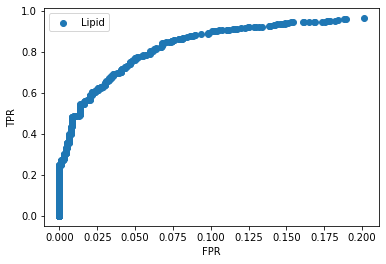

In [5]:
plt.scatter(fpr_lipid.values(), tpr_lipid.values(), label='Lipid')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [22]:
tpr_cal, fpr_cal = get_roc('calcium', 101000, 100)

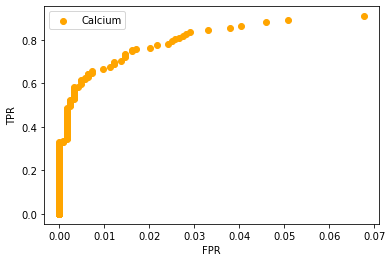

In [23]:
plt.scatter(fpr_cal.values(), tpr_cal.values(), label='Calcium', c='orange')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

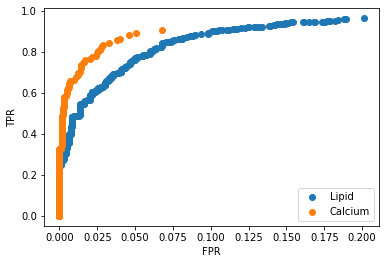

In [24]:
plt.scatter(fpr_lipid.values(), tpr_lipid.values(), label='Lipid')
plt.scatter(fpr_cal.values(), tpr_cal.values(), label='Calcium')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# See new CM

In [7]:
test_raw = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\counts\second_split\pseudo3d_get_thresh.xlsx', sheet_name='Raw test')
test_2d = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\counts\second_split\pseudo3d_get_thresh.xlsx', sheet_name='2D')
test_1 = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\counts\second_split\pseudo3d_get_thresh.xlsx', sheet_name='k=1')
test_2 = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\counts\second_split\pseudo3d_get_thresh.xlsx', sheet_name='k=2')
test_3 = pd.read_excel(r'Z:\grodriguez\CardiacOCT\info-files\counts\second_split\pseudo3d_get_thresh.xlsx', sheet_name='k=3')

In [12]:
def get_cm(region: str, model_data: pd.DataFrame, thresh: int) -> Tuple[dict, dict]:
    """Get both CM before and after applying the threshold to compare

    Args:
        region (str): lipid or calcium
        model_data (pd.DataFrame): one of the dataframes with the sizes on the test set for a given model
        thresh (int): optimal thresh found in previous functions

    Returns:
        dict, dict: dict with the conf matrices before and after
    """    

    list_cm = []
    list_cm_thresh = []
        
    for i in range(len(model_data)):
        
        if model_data[region][i] == 0 and test_raw[region][i] == 1:
            list_cm.append('FN')
            list_cm_thresh.append('FN')

        elif model_data[region][i] == 0 and test_raw[region][i] == 0:
            list_cm.append('TN')
            list_cm_thresh.append('TN')

        else:

            if (model_data[region][i] == 1 and test_raw[region][i] == 1) and model_data['{} size'.format(region)][i] <= thresh:
                list_cm_thresh.append('FN')
                list_cm.append('TP')

            elif (model_data[region][i] == 1 and test_raw[region][i] == 1) and model_data['{} size'.format(region)][i] > thresh:
                list_cm.append('TP')
                list_cm_thresh.append('TP')


            if (model_data[region][i] == 1 and test_raw[region][i] == 0) and model_data['{} size'.format(region)][i] <= thresh:
                list_cm_thresh.append('TN')
                list_cm.append('FP')

            elif (model_data[region][i] == 1 and test_raw[region][i] == 0) and model_data['{} size'.format(region)][i] > thresh:
                list_cm.append('FP')
                list_cm_thresh.append('FP')

    return Counter(list_cm), Counter(list_cm_thresh)

In [13]:
def get_sens_spec(cm: dict) -> Tuple[float, floats]:
    """Get sensitivity and specificity given CM

    Args:
        cm (dict): dict with confusion matrix

    Returns:
        float, float: sens and spec values 
    """    
    sens = cm['TP'] / (cm['TP'] + cm['FN'])
    spec = cm['TN'] / (cm['TN'] + cm['FP'])

    return sens, spec

In [37]:
cm_old, cm_new = get_cm('calcium', test_3, 100)
print('CM old', cm_old)
print('CM new', cm_new)

sens_old, spec_old = get_sens_spec(cm_old)
sens_new, spec_new = get_sens_spec(cm_new)

print('Sens old: {} Sens new: {}'.format(sens_old, sens_new))
print('Spec new: {} Spec new: {}'.format(spec_old, spec_new))

CM old Counter({'TN': 151, 'TP': 46, 'FP': 13, 'FN': 8})
CM new Counter({'TN': 153, 'TP': 45, 'FP': 11, 'FN': 9})
Sens old: 0.8518518518518519 Sens new: 0.8333333333333334
Spec new: 0.9207317073170732 Spec new: 0.9329268292682927
